# <u>Walmart Product Review Analysis <u/>

### Goal
This analysis will look at Walmart clothing reviews to find key features that predict whether a customer will recommend an item or not. This investigation will be conducted using [Natural Language Processing](https://en.wikipedia.org/wiki/Natural_language_processing) packages and libraries. The features that guide the predictions can then used to guide Walmart's online and/or in-store marketing/product campaigns. 

### Notebook
Notebook ```1_walmart_product_review_nlp``` has cleaned the continuous variables. 
This notebook will be focused on the preprocessing steps for the text data which included, tokenization, removal of stopwords, lemmatization and Latend Dirichlet Allocation (LDA) model. 

In [1]:
# Data Cleaning and analysis libraries and packages
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 200)

import os
import sys

module_path = os.path.abspath(os.path.join('./scripts'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import preprocessing as pp
import visual as vis

# NLP libraries and packages
import re
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora, models
from sklearn.preprocessing import OneHotEncoder


# Visualization libraries and packages
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore") 


# Modeling libraries and packages
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, roc_curve


from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier




In [2]:
#importing cleaned dataframe for preprocessing the texts. 
clean_df = pd.read_csv("data/clean_df.csv", index_col = 0)

In [3]:
clean_df.head()

,item_name,price,overall_rating,num_rating,recommend,rev_title,review_text,section,target,rating_bin
0,Wrangler Men's Unlined Shirt Jacket,12.0,4.0,7.0,80.0,['Texas winter ready!'],['I bought this last year and am going to buy ...,men's clothing,0,1
1,Wrangler Men's Relaxed Fit Jeans,12.0,4.5,5840.0,90.0,"['Wrangler is the best.', 'My Favorite Jeans',...","['I like wrangler, the pants is exactly for my...",men's clothing,1,1
2,Wrangler Big Men's Relaxed Fit Jean,15.0,4.3,3257.0,88.0,"['Jeans That Fit Just Right', 'Great jeans wou...","[""If you like Big Men's style wearing jeans th...",men's clothing,1,1
3,Wrangler Men's 5 Star Regular Fit Jean with Flex,12.0,4.5,259.0,91.0,"['Committed buyer', 'More Comfortable than Swe...",['My husband loves these jeans and goes throug...,men's clothing,1,1
4,Wrangler Men's and Big Men's 5 Star Relaxed Fi...,15.0,4.6,1490.0,91.0,['Saved money and faster delivery that Amazon'...,['Fit well Great price same jeans I was buying...,men's clothing,1,2


The raw review_text has a lot of noise. Will need to use regex to filter out all unnecesary characters. I will also remove numbers and apostrophes. 

In [4]:
#  def clean_text(text):
#     text.replace("\\n"," ")
#     text =  ' '.join(re.sub("([^A-Za-z0-9!.])"," ",text).split())
#     return text

In [5]:
clean_df["clean_reviews"]= clean_df["review_text"].apply(pp.clean_text)

In [6]:
clean_df["clean_reviews"][5]

'They were exactly what I was searching for! Nice thick material and definitely worth the price. Ive seen the exact same ones in other stores for 50 60. I did the next day shipping because I needed them for a camping trip two days after I ordered and still had to iron on the vinyl. It delivered right on time which I was nervous about. I actually did not expect this hoodie to be this comfortable and warm. I bought the purple hoodie and i thought it was going to be a light purple but im still happy with this color I got these sweatshirts in white for my boyfriend and I to tie dye using two shades of blue Ritt Dye. The fabric held the color BEAUTIFULLY and out horsies turned out so dreamy!! 100 recommend. Super soft inside and a medium weight. Great quality and despite the pandemic it came on time! This review was collected as part of a promotion. I am a HUGE fan of the Powerblend Hoodie! I have several and I love the softness comfort and quality of the materials and workmanship. I m a fe

In [7]:
clean_df.head(2)

,item_name,price,overall_rating,num_rating,recommend,rev_title,review_text,section,target,rating_bin,clean_reviews
0,Wrangler Men's Unlined Shirt Jacket,12.0,4.0,7.0,80.0,['Texas winter ready!'],['I bought this last year and am going to buy ...,men's clothing,0,1,I bought this last year and am going to buy an...
1,Wrangler Men's Relaxed Fit Jeans,12.0,4.5,5840.0,90.0,"['Wrangler is the best.', 'My Favorite Jeans',...","['I like wrangler, the pants is exactly for my...",men's clothing,1,1,I like wrangler the pants is exactly for my bo...


# Creating Baseline Models
Baseline models will be used to determine our starting point. Based on the results from the models, I will find ways to improve by either tuning the hyperparameters and/or feature engineering. 

In [8]:
X = clean_df.drop(columns = ["item_name", "overall_rating", "recommend", "rev_title", "review_text", "section", "target"])
y = clean_df["target"].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [10]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(804, 4) (804,) (345, 4) (345,)


# TfidfVectorizer:
TF-IDF stands for Term Frequency-Inverse Document Frequency, which provides a frequency score to highlight words that are more frequent in one document but not across all documents. 

I will use TfidfVectorizer to find important and unique words for each document when compared to the rest of the documents. 

In [11]:
tfidfvec = TfidfVectorizer(lowercase=False) 

train_vec = tfidfvec.fit_transform(X_train.clean_reviews.values)
test_vec = tfidfvec.transform(X_test.clean_reviews.values)

### Modeling

In [12]:
logreg_clf = LogisticRegression(penalty = "l2", random_state = 0,n_jobs=-1, )
logreg_clf.fit(train_vec, y_train)

LogisticRegression(n_jobs=-1, random_state=0)

In [13]:
y_pred_lr = logreg_clf.predict(test_vec)
print("F1 score is:", metrics.f1_score(y_test, y_pred_lr))
print("Recall score is:", metrics.recall_score(y_test, y_pred_lr))
print("Precision score is:", metrics.precision_score(y_test, y_pred_lr))
print("="*60)
print(classification_report(y_test, y_pred_lr))


F1 score is: 0.8783783783783784
Recall score is: 0.9885931558935361
Precision score is: 0.790273556231003
              precision    recall  f1-score   support

           0       0.81      0.16      0.27        82
           1       0.79      0.99      0.88       263

    accuracy                           0.79       345
   macro avg       0.80      0.57      0.57       345
weighted avg       0.80      0.79      0.73       345



In [14]:
y_pred_lr = logreg_clf.predict(train_vec)
print("F1 score is:", metrics.f1_score(y_train, y_pred_lr))
print("Recall score is:", metrics.recall_score(y_train, y_pred_lr))
print("Precision score is:", metrics.precision_score(y_train, y_pred_lr))
print("="*60)
print(classification_report(y_train, y_pred_lr))

F1 score is: 0.88
Recall score is: 0.9982547993019197
Precision score is: 0.7867950481430537
              precision    recall  f1-score   support

           0       0.99      0.33      0.49       231
           1       0.79      1.00      0.88       573

    accuracy                           0.81       804
   macro avg       0.89      0.66      0.69       804
weighted avg       0.84      0.81      0.77       804



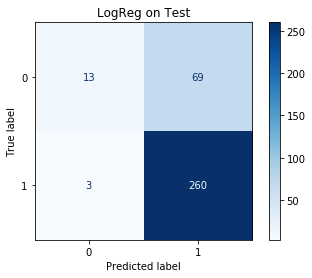

In [15]:
vis.con_mat(logreg_clf, test_vec, y_test, title="LogReg on Test")

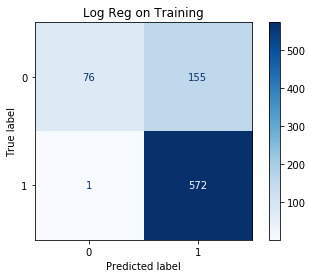

In [16]:
vis.con_mat(logreg_clf, train_vec, y_train, title="Log Reg on Training")

As of right now, my model is overfit. This might be due to the large class imbalance or perhaps the Model is having a hard time classifying based on the words since words appear in both recommended and not recommended. 
|

# Review text is now clean and ready to be used for feature engineering. 
Preprocessing steps:
- Tokenize
- Indentify stopwords
- Lemmatize

Tokeniziation will be done using the tokenize function from preproscessing.py file. 
This funciton will sepereate all words 

In [17]:
# lemmatizer = nltk.stem.WordNetLemmatizer()
# # initilizing stopwords. 
# stop_words=list(set(stopwords.words("english")))

In [18]:
# creating a new column of tekenized words.
clean_df["tokenized"] = clean_df.clean_reviews.apply(pp.tokenize)

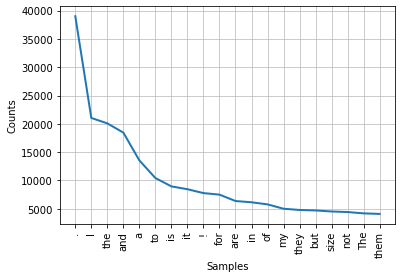

Number of words in corpus: 14481


In [19]:
vis.fdist(clean_df, "tokenized")

As expected, the high frequency words are stopwords, which provide little to no insight. 

In [20]:
# creating a new column with stopwords removed
clean_df["rem_stop"] = clean_df.tokenized.apply(pp.remove_stopwords)

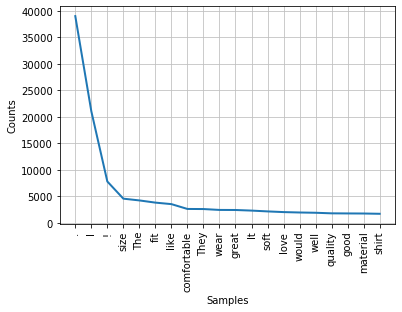

Number of words in corpus: 14334


In [21]:
vis.fdist(clean_df, "rem_stop")

After removing the stopwords (dropped 83 words), we see more descriptive words, which could be useful features in predicting the target. 

In [22]:
clean_df["lemma_words"] = clean_df.rem_stop.apply(pp.lemmatize_text)

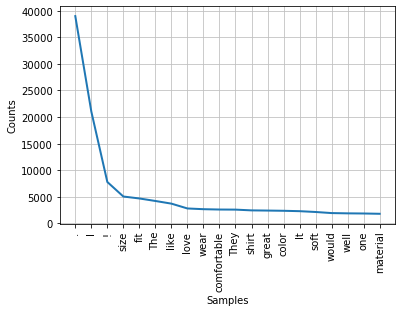

Number of words in corpus: 13319


In [23]:
vis.fdist(clean_df, "lemma_words")

Interestingly, size and fit seem to be very important and constantly refered to based on the FreqDist. Doing more EDA on this would be beneficial. I will also use wordclouds to see the importance of other words across recommended and non recommended items.

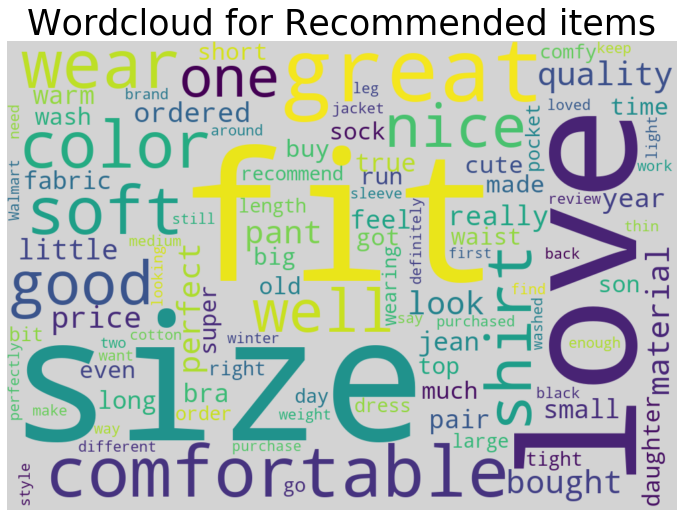

In [24]:
vis.pos_cloud(clean_df, "target")

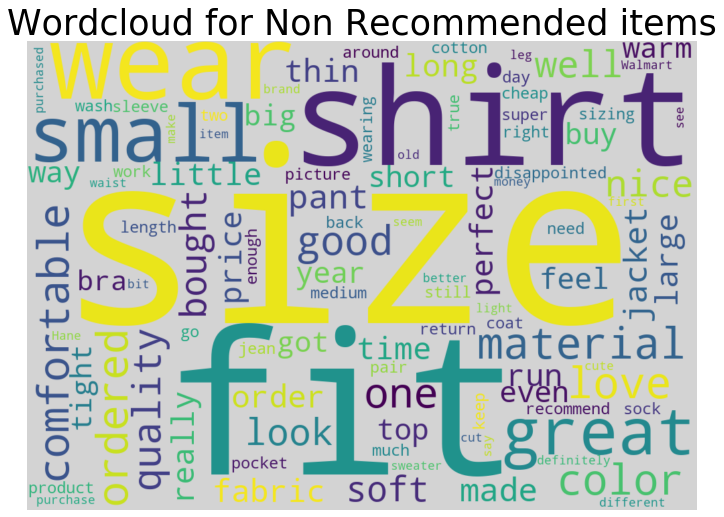

In [25]:
vis.neg_cloud(clean_df, "target")

# DID NOT REMOVE SIZE AND FIT

Since size and fit are in both recommended and non recommended items, I will add this to the stopwords. However, it is important to note that these are the most frequest words in the corpus and need to be addressed in the findings. 

Adding new stopwords found from the word cloud. 

In [48]:
eda_stopwords = ["color", "size", "fit", "great", "pair", "right", "x", "xl", "nd", "de", "u", "la", "tbw", "c", "v", "great", "n", "wal", "wow","hi", "hello", "nmbc", "youll", "must", "said", "either", "lol", 'ill', "six", "goat", "thou", "un", "lb", "pair", "right", "x", "xl", "one", "way", "definitely", "shirt", "jacket", "daughter", "son" ]

stop_words=list(set(stopwords.words("english")))

stop_words.extend(eda_stopwords)

In [49]:
# removing the list around lemma_words for future feature engineering.
# def list_to_str(text):
#     return ", ".join(text)

clean_df["delisted"] = clean_df["lemma_words"].apply(ppros.list_to_str)

Since the section column is categorical, I will use OneHotEncoder to code it so it can be intrepreted by models. I do not believe these will be important features since we found them all to have roughly an even spread.

In [50]:
def coded_encoder(df, column):
    encoder = OneHotEncoder(handle_unknown="error", drop="first" )
    coded=pd.DataFrame(encoder.fit_transform(df[[column]]).toarray())
    coded.rename(columns={0:"girls'", 1:"men's", 2:"women's"},inplace=True)
    df.drop(columns = column, inplace=True)
    return coded

In [26]:
# encoder = OneHotEncoder(handle_unknown="error", drop="first" )
# coded_cat=pd.DataFrame(encoder.fit_transform(clean_df[["section"]]).toarray())
# coded_cat.rename(columns={0:"girls'", 1:"men's", 2:"women's"},inplace=True)
# df.drop(columns = column, inplace=True)

In [51]:
coded_cat = coded_encoder(clean_df, "section")

In [52]:
# combining the new dataframe of coded section with the main dataframe. 
frames = [clean_df, coded_cat]
df = pd.concat(frames, axis=1)

In [54]:
df.head()

,item_name,price,overall_rating,num_rating,recommend,rev_title,review_text,target,rating_bin,clean_rev_title,clean_review_text,tokenized,rem_stop,lemma_words,delisted,girls',men's,women's
0,Wrangler Men's Unlined Shirt Jacket,12.0,4.0,7.0,80.0,['Texas winter ready!'],['I bought this last year and am going to buy ...,0,1,texas winter ready,i bought this last year and am going to buy an...,"[i, bought, this, last, year, and, am, going, ...","[bought, last, year, going, buy, another, frid...","[bought, last, year, going, buy, another, frid...","bought, last, year, going, buy, another, frida...",0.0,1.0,0.0
1,Wrangler Men's Relaxed Fit Jeans,12.0,4.5,5840.0,90.0,"['Wrangler is the best.', 'My Favorite Jeans',...","['I like wrangler, the pants is exactly for my...",1,1,wrangler is the best my favorite jeans extreme...,i like wrangler the pants is exactly for my bo...,"[i, like, wrangler, the, pants, is, exactly, f...","[like, wrangler, pants, exactly, body, also, g...","[like, wrangler, pant, exactly, body, also, go...","like, wrangler, pant, exactly, body, also, goo...",0.0,1.0,0.0
2,Wrangler Big Men's Relaxed Fit Jean,15.0,4.3,3257.0,88.0,"['Jeans That Fit Just Right', 'Great jeans wou...","[""If you like Big Men's style wearing jeans th...",1,1,jeans that fit just right great jeans would bu...,if you like big men s style wearing jeans thes...,"[if, you, like, big, men, s, style, wearing, j...","[like, big, men, style, wearing, jeans, right,...","[like, big, men, style, wearing, jean, right, ...","like, big, men, style, wearing, jean, right, w...",0.0,1.0,0.0
3,Wrangler Men's 5 Star Regular Fit Jean with Flex,12.0,4.5,259.0,91.0,"['Committed buyer', 'More Comfortable than Swe...",['My husband loves these jeans and goes throug...,1,1,committed buyer more comfortable than sweatpan...,my husband loves these jeans and goes through ...,"[my, husband, loves, these, jeans, and, goes, ...","[husband, loves, jeans, goes, quite, lot, thro...","[husband, love, jean, go, quite, lot, througho...","husband, love, jean, go, quite, lot, throughou...",0.0,1.0,0.0
4,Wrangler Men's and Big Men's 5 Star Relaxed Fi...,15.0,4.6,1490.0,91.0,['Saved money and faster delivery that Amazon'...,['Fit well Great price same jeans I was buying...,1,2,saved money and faster delivery that amazon ve...,fit well great price same jeans i was buying o...,"[fit, well, great, price, same, jeans, i, was,...","[fit, well, great, price, jeans, buying, amazo...","[fit, well, great, price, jean, buying, amazon...","fit, well, great, price, jean, buying, amazon,...",0.0,1.0,0.0


Before we dive into LDA modeling, I need to remove the added stopwords that were discovered from the wordcloud. 

In [56]:
clean_df["lemma_words"] = clean_df["lemma_words"].apply(pp.remove_stopwords)

# LDA (Topic) Model

The reason for creating a topic model is to see if there are words that can be grouped together. I hypothesize that there will be no luck with finding good topic models but its worth the try. The algorithm might find something that I missed in my eda. 

In [57]:
# creating a dictionary from the delisted column. 
# There is no difference between the delisted and lemm_words column when it comes to the words itself. 
# So I will use the two interchangeably depending on which works. 
dataset = [d.split() for d in clean_df.delisted]
vocab = gensim.corpora.Dictionary(dataset)


In [58]:
dictionary = gensim.corpora.Dictionary(clean_df["lemma_words"])
dictionary.filter_extremes(no_above=0.5)

In [59]:
sparce_matrix = [dictionary.doc2bow(doc) for doc in clean_df["lemma_words"]]

In [60]:
tfidf = models.TfidfModel(sparce_matrix)
corpus_tfidf = tfidf[sparce_matrix]

In [61]:
%%time
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf,  num_topics=10, id2word=vocab, passes=50, workers=8, random_state=0)

CPU times: user 1min 28s, sys: 3.35 s, total: 1min 31s
Wall time: 1min 39s


In [62]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} \n\Word: {}\n'.format(idx, topic))

Topic: 0 
\Word: 0.002*"male," + 0.002*"fidnt," + 0.002*"kiddos," + 0.002*"nwould," + 0.001*"medication," + 0.001*"earth," + 0.001*"proportion," + 0.001*"detaches," + 0.001*"aside," + 0.001*"fedex,"

Topic: 1 
\Word: 0.001*"stylist," + 0.001*"worn," + 0.000*"universal," + 0.000*"retailer," + 0.000*"spacious," + 0.000*"tightness," + 0.000*"trick," + 0.000*"wash," + 0.000*"developed," + 0.000*"toasty,"

Topic: 2 
\Word: 0.007*"u," + 0.005*"navy," + 0.004*"daughter," + 0.004*"purchasing," + 0.004*"amazing," + 0.004*"great," + 0.004*"aglet," + 0.004*"stitch," + 0.003*"waistband," + 0.003*"bulky,"

Topic: 3 
\Word: 0.007*"keep," + 0.004*"ask," + 0.003*"asked," + 0.003*"thx," + 0.003*"chicken," + 0.003*"mesh," + 0.002*"crooked," + 0.002*"youll," + 0.002*"mentioned," + 0.002*"doesnt,"

Topic: 4 
\Word: 0.003*"drew," + 0.003*"functional," + 0.001*"noverall," + 0.001*"nthis," + 0.000*"thx," + 0.000*"tan," + 0.000*"latter," + 0.000*"aside," + 0.000*"surprisingly," + 0.000*"trouser,"

Topic: 5 
\

In [63]:
corpus_transformed = lda_model_tfidf[sparce_matrix]

In [64]:
%%time
# convert to dataframe
topics = [dict(x) for x in corpus_transformed]

# convert list of lda topic weights to dataframe
lda_tfidf_df = pd.DataFrame(topics)
# rename columns
lda_tfidf_df.rename(columns={i: f'topic{i}' for i in range(10)}, inplace=True)

lda_tfidf_df.fillna(0, inplace=True)

CPU times: user 199 ms, sys: 5.81 ms, total: 205 ms
Wall time: 207 ms


In [65]:
#confirming the dataframe is valid.
lda_tfidf_df

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,0.011115,0.011115,0.789003,0.122076,0.011115,0.011115,0.011115,0.011115,0.011115,0.011115
1,0.000000,0.000000,0.957856,0.024084,0.000000,0.000000,0.000000,0.000000,0.000000,0.016621
2,0.000000,0.000000,0.944305,0.021740,0.000000,0.000000,0.000000,0.000000,0.000000,0.027335
3,0.000000,0.000000,0.957795,0.013038,0.000000,0.000000,0.000000,0.000000,0.000000,0.026161
4,0.000000,0.000000,0.972463,0.013723,0.000000,0.000000,0.000000,0.000000,0.000000,0.011794
...,...,...,...,...,...,...,...,...,...,...
1144,0.011112,0.011112,0.899989,0.011112,0.011112,0.011112,0.011112,0.011112,0.011112,0.011112
1145,0.000000,0.000000,0.957136,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1146,0.000000,0.000000,0.983015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1147,0.000000,0.000000,0.980495,0.011255,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Topic 6 seems to be dominating the dataframe. 
This may be because customers are describing how either their puchase was a "mistake" or how it was "worth" the price. This is something I will need to take into consideration in the modeling notebook. Thus, I need to join the LDA topic modeling dataframe with the main dataframe. 

Topic: 6 
\Word: 0.005*"mistake," + 0.004*"worth," + 0.004*"grateful," + 0.004*"supposed," + 0.004*"seen," + 0.003*"chose," + 0.003*"present," + 0.003*"half," + 0.003*"puffy," + 0.003*"pre,"

Topic: 3 
\Word: 0.005*"month," + 0.004*"refrigerated," + 0.004*"grew," + 0.004*"tossed," + 0.004*"snag," + 0.003*"happens," + 0.003*"probably," + 0.003*"lazy," + 0.003*"sweatsuit," + 0.003*"preferred,"


In [66]:
frames = [df, lda_tfidf_df]
df = pd.concat(frames, axis=1)
#confirming the merge worked
df.shape

(1149, 28)

Converting the dataframe to ```.csv``` introduces unwanted noise and corrupts the dataframe. Dataframe will be pickled to be used in the next notebook for modeling. 

In [67]:
import pickle

In [68]:
filename = "data/modeling_df.pkl"
outfile = open(filename, "wb")

In [69]:
pickle.dump(df,outfile)
outfile.close

<function BufferedWriter.close>